<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Versions/SephModelV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Seph's ModelV5 Development

This notebook demonstrates the development of a custom neural network using TensorFlow and Keras, focusing on good coding practices and clear documentation.

### Library Imports
All necessary libraries are imported here for better organization.


In [ ]:
%%capture
!pip install tensorflow keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Synthetic Sensor data

-------------------------

In [ ]:
df = pd.read_csv('/content/synthetic_datasetV2.csv')
df.head(10)

,timestamp,action,reward,alpha,beta,delta,epsilon,eta,gamma,iota,...,sensor_126_diff,sensor_126_roll_avg,sensor_126_exp_mov_avg,sensor_126_lag_1,sensor_127_diff,sensor_127_roll_avg,sensor_127_exp_mov_avg,sensor_127_lag_1,sensor_mean,sensor_std
0,2024-02-03 05:38:10,3,-0.056821,0.000000,0.000000,0.816452,0.000000,0.412571,0.403969,0.000000,...,0.129797,-1.136164,-1.081711,-1.112852,0.056612,-0.142496,-0.188089,-0.102271,0.022779,1.014461
1,2024-02-03 05:27:37,3,0.907599,0.000000,0.000000,0.410918,0.000000,0.000000,0.813266,0.000000,...,-0.213815,-0.311204,-0.326941,-0.540476,0.034856,-0.084076,-0.031777,-0.079061,0.028387,1.018413
2,2024-02-03 05:27:32,3,0.737502,0.393944,0.403244,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.256003,0.760693,0.716943,0.623687,-0.131104,0.271732,0.257087,0.135298,0.110811,1.035087
3,2024-02-03 05:31:55,3,-0.842084,0.700677,0.000000,0.000000,0.000000,0.000000,0.713479,0.000000,...,0.064810,-0.403378,-0.375861,-0.376477,0.068926,0.808229,0.746149,0.876656,-0.011083,0.952480
4,2024-02-03 05:31:18,3,0.314379,0.000000,0.000000,0.752898,0.000000,0.000000,0.000000,0.378943,...,0.020419,-0.002146,-0.005821,-0.073236,0.085244,1.780611,1.713498,1.732328,-0.211948,1.004894
5,2024-02-03 05:34:10,3,0.564325,0.000000,0.000000,0.000000,0.884623,0.000000,0.000000,0.000000,...,0.265308,-1.300098,-1.239570,-1.132283,-0.103897,1.461013,1.397425,1.460604,-0.108008,1.031087
6,2024-02-03 05:33:05,3,0.789867,0.000000,0.895359,0.000000,0.000000,0.000000,0.445345,0.000000,...,-0.160482,0.771008,0.704103,0.513192,-0.169728,1.886030,1.800859,1.897871,-0.241431,1.007688
7,2024-02-03 05:40:16,3,-0.434471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.128779,-1.323286,-1.277699,-1.497565,0.125176,-0.879830,-0.813615,-0.655383,0.078919,1.049465
8,2024-02-03 05:29:23,3,0.410669,0.000000,0.000000,0.000000,0.855303,0.000000,0.296650,0.301762,...,0.253545,-0.897371,-0.870099,-0.728895,0.088115,0.213095,0.241520,0.353181,-0.082863,1.051077
9,2024-02-03 05:33:31,3,0.561655,0.000000,0.000000,0.000000,0.388413,0.825505,0.000000,0.000000,...,0.210295,0.017003,0.052767,0.323389,0.160286,-0.665811,-0.629482,-0.504049,-0.024341,1.035294



## Custom Layer Definitions

Here we define custom layers with appropriate documentation and naming conventions.

### BoolformerLayer

This custom TensorFlow layer performs a logical AND operation on its input and then processes it through a dense layer with ReLU activation. It has been enhanced with a trainable threshold and an attention mechanism. The inputs are transformed into boolean values based on the threshold, embedded, and processed through multi-head attention before being passed to a dense ReLU layer.


In [ ]:
# Custom Layer for Boolformer, with added trainable threshold and attention mechanism
class BoolformerLayer(layers.Layer):
    def __init__(self, embedding_dim=8, num_heads=2, threshold_init_value=0.5, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.threshold_init_value = threshold_init_value

    def build(self, input_shape):
        self.threshold = self.add_weight(
            name='threshold',
            shape=(input_shape[-1],),
            initializer=tf.constant_initializer(self.threshold_init_value),
            trainable=True
        )
        self.embedding_layer = layers.Embedding(input_dim=2, output_dim=self.embedding_dim)
        self.attention_layer = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)
        self.dense_layer = layers.Dense(input_shape[-1], activation='relu')

    def call(self, inputs):
        boolean_inputs = tf.greater(inputs, self.threshold)
        embeddings = self.embedding_layer(tf.cast(boolean_inputs, dtype=tf.int32))
        attention_output = self.attention_layer(embeddings, embeddings)
        attention_output_flat = tf.reshape(attention_output, [-1, attention_output.shape[1] * self.embedding_dim])
        return self.dense_layer(attention_output_flat)



### QLearningLayer

This layer is designed for reinforcement learning tasks, using a Q-learning algorithm to learn the quality of actions.


In [ ]:
class QLearningLayer(layers.Layer):
    def __init__(self, action_space_size, learning_rate=0.01, gamma=0.95, **kwargs):
        super(QLearningLayer, self).__init__(**kwargs)
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.gamma = gamma

    def build(self, input_shape):
        # A dense layer to process state and output Q-values for each action
        self.dense = layers.Dense(self.action_space_size, activation=None)

    def call(self, state, action=None, reward=None, next_state=None):
        q_values = self.dense(state)

        if action is not None and reward is not None and next_state is not None:
            # Get the predicted Q-values for the next state
            future_q_values = self.dense(next_state)
            max_future_q = tf.reduce_max(future_q_values, axis=1)

            # Compute the updated Q-value for the chosen action
            q_update = reward + self.gamma * max_future_q
            q_values_with_update = tf.tensor_scatter_nd_update(
                q_values, tf.expand_dims(action, axis=-1), q_update)

            # Update the Q-values
            self.dense.set_weights([q_values_with_update])

        return q_values


## Helper Functions

Defining helper functions such as positional encoding and transformer encoder with detailed comments for better understanding.



### Positional Encoding Function

Positional encoding adds information about the position of elements in the input sequence, crucial for models like transformers.


In [ ]:
def positional_encoding(seq_length, d_model):
    position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))

    # Creating sine and cosine functions separately and then concatenating them
    sine_terms = tf.sin(position * div_term)
    cosine_terms = tf.cos(position * div_term)

    # Interleaving sine and cosine terms
    pos_encoding = tf.reshape(tf.concat([sine_terms, cosine_terms], axis=-1), [1, seq_length, d_model])

    return pos_encoding


### Transformer Encoder Function

The transformer encoder function applies transformations to the input data using layer normalization and multi-head attention, followed by a series of dense layers.


In [ ]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res



## Model Building and Compilation

Here we build and compile the neural network model, ensuring clarity and efficiency in the code.


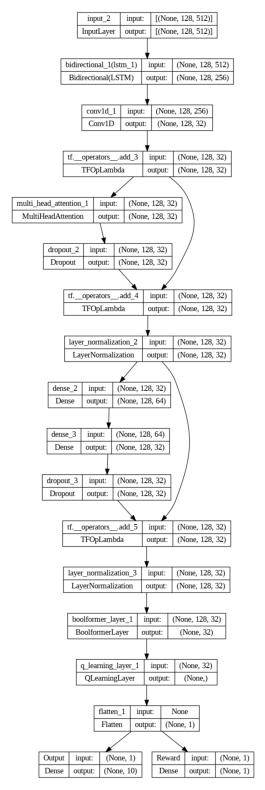

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 512)]           0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 128, 256)             656384    ['input_2[0][0]']             
 onal)                                                                                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 128, 32)              24608     ['bidirectional_1[0][0]']     
                                                                                                  
 tf.__operators__.add_3 (TF  (None, 128, 32)              0         ['conv1d_1[0][0]']      

In [ ]:
class BoolformerLayer(layers.Layer):
    def __init__(self, embedding_dim=8, num_heads=2, threshold_init_value=0.5, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.threshold_init_value = threshold_init_value

    def build(self, input_shape):
        self.threshold = self.add_weight(
            name='threshold',
            shape=(input_shape[-1],),
            initializer=tf.constant_initializer(self.threshold_init_value),
            trainable=True
        )
        self.embedding_layer = layers.Embedding(input_dim=2, output_dim=self.embedding_dim)
        self.attention_layer = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)
        self.attention_norm_layer = layers.LayerNormalization(epsilon=1e-6)
        self.dense_layer = layers.Dense(input_shape[-1], activation='relu')

    def call(self, inputs):
        boolean_inputs = tf.greater(inputs, self.threshold)
        embeddings = self.embedding_layer(tf.cast(boolean_inputs, dtype=tf.int32))
        attention_output = self.attention_layer(embeddings, embeddings)
        attention_output_norm = self.attention_norm_layer(attention_output)
        attention_output_flat = tf.reshape(attention_output_norm, shape=[-1, attention_output.shape[1] * self.embedding_dim])
        return self.dense_layer(attention_output_flat)

class QLearningLayer(layers.Layer):
    def __init__(self, action_space_size, state_size, learning_rate=0.01, gamma=0.95, epsilon=0.1, **kwargs):
        super().__init__(**kwargs)
        self.action_space_size = action_space_size
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def build(self, input_shape):
        self.q_network = layers.Dense(self.action_space_size)

    def call(self, state, action=None, reward=None, next_state=None):
        q_values = self.q_network(state)

        if action is not None and reward is not None and next_state is not None:
            next_state_q_values = self.q_network(next_state)
            target_q_value = reward + self.gamma * tf.reduce_max(next_state_q_values, axis=1)
            mask = tf.one_hot(action, self.action_space_size)

            with tf.GradientTape() as tape:
                current_q_values = self.q_network(state)
                q_action = tf.reduce_sum(tf.multiply(current_q_values, mask), axis=1)
                loss = tf.reduce_mean(tf.square(target_q_value - q_action))

            grads = tape.gradient(loss, self.q_network.trainable_variables)
            self.q_network.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

        action_probabilities = tf.nn.softmax(q_values, axis=1)
        chosen_action = tf.cond(
            tf.random.uniform([], 0, 1) < self.epsilon,
            lambda: tf.random.uniform([tf.shape(state)[0]], 0, self.action_space_size, dtype=tf.int64),
            lambda: tf.argmax(action_probabilities, axis=1)
        )
        return chosen_action

def positional_encoding(seq_length, d_model):
    position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model // 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    pos_encoding = position * div_term
    sin_cos_encoding = tf.concat([tf.sin(pos_encoding), tf.cos(pos_encoding)], axis=-1)
    return sin_cos_encoding[tf.newaxis, ...]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

def create_neural_network_model(seq_length, d_model, num_classes):
    input_layer = keras.Input(shape=(seq_length, d_model))

    pos_encoding = positional_encoding(seq_length, 32)

    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(input_layer)
    x_conv = layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x_lstm)

    x_pos_encoded = x_conv + pos_encoding

    transformer_output = transformer_encoder(x_pos_encoded, head_size=32, num_heads=2, ff_dim=64)

    state_size = transformer_output.shape[1] * transformer_output.shape[2]
    x_bool = BoolformerLayer()(transformer_output)
    rl_layer = QLearningLayer(action_space_size=num_classes, state_size=state_size)(x_bool)

    # Flatten the output from QLearningLayer before final dense layers
    reshaped_output = layers.Flatten()(rl_layer)

    output_layer = layers.Dense(num_classes, activation='softmax', name='Output')(reshaped_output)
    reward_layer = layers.Dense(1, name='Reward')(reshaped_output)

    model = keras.Model(inputs=input_layer, outputs=[output_layer, reward_layer])

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss={'Output': 'categorical_crossentropy', 'Reward': 'mean_squared_error'},
                  metrics={'Output': 'accuracy'})

    return model

seq_length = 128
d_model = 512
num_classes = 10

model = create_neural_network_model(seq_length, d_model, num_classes)

# Visualizing the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Displaying the model architecture image
image = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

# Printing the model summary
model.summary()

## Model Training

In this section, we train the neural network model using the specified hyperparameters. The `model.fit()` function will be used to train the model with the training data. The validation data will be used to monitor the model's performance on unseen data.

In [ ]:
# Data Preparation
# Auto-detecting output and reward columns based on model architecture
output_label_column = df.columns[-2]  # Change this as per DataFrame Structure
reward_label_column = df.columns[-1]  # Change this as per DataFrame Structure
input_columns = df.drop([output_label_column, reward_label_column], axis=1)

# Standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(input_columns)

# Preparing output and reward labels
Y_output = df[output_label_column].values  # Assuming categorical labels
Y_reward = df[reward_label_column].values  # Assuming continuous values

# Splitting the dataset
X_train, X_val, Y_output_train, Y_output_val, Y_reward_train, Y_reward_val = train_test_split(
    X, Y_output, Y_reward, test_size=0.2, random_state=42
)

# Formatting data for model training
train_data = (X_train, {'Output': Y_output_train, 'Reward': Y_reward_train})
val_data = (X_val, {'Output': Y_output_val, 'Reward': Y_reward_val})

# Model Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min'),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_data,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_data,
    verbose=1,
    callbacks=callbacks
)

# Model Saving
model.save('SephsRL.h5')

## Model Evaluation

After training the model, it's important to evaluate its performance on a test dataset to understand its efficacy. The following code will use the `model.evaluate()` function to assess the model's accuracy and loss on the test data.

In [ ]:
# Evaluate the model on the test data
# test_data = ...

evaluation_metrics = model.evaluate(test_data)
print(f"Test Loss: {evaluation_metrics[0]}, Test Accuracy: {evaluation_metrics[1]}")


## Visualizing Model Performance

Functions for plotting and analyzing the model's performance during training.


In [ ]:

import matplotlib.pyplot as plt

# Function to plot training history for both 'Output' and 'Reward' outputs, tailored to their characteristics
def plot_custom_output_history(history):
    num_plots = 2 + ('accuracy' in history.history)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    plot_index = 0

    # Plotting accuracy for 'Output', if it's available
    if 'accuracy' in history.history:
        axes[plot_index].plot(history.history['accuracy'], label='Training Accuracy - Output')
        axes[plot_index].plot(history.history['val_accuracy'], label='Validation Accuracy - Output')
        axes[plot_index].set_title('Accuracy for Output')
        axes[plot_index].set_xlabel('Epochs')
        axes[plot_index].set_ylabel('Accuracy')
        axes[plot_index].legend()
        plot_index += 1

    # Plotting loss for 'Output'
    axes[plot_index].plot(history.history['Output_loss'], label='Training Loss - Output')
    axes[plot_index].plot(history.history['val_Output_loss'], label='Validation Loss - Output')
    axes[plot_index].set_title('Loss for Output')
    axes[plot_index].set_xlabel('Epochs')
    axes[plot_index].set_ylabel('Loss')
    axes[plot_index].legend()
    plot_index += 1

    # Plotting loss for 'Reward'
    axes[plot_index].plot(history.history['Reward_loss'], label='Training Loss - Reward')
    axes[plot_index].plot(history.history['val_Reward_loss'], label='Validation Loss - Reward')
    axes[plot_index].set_title('Loss for Reward')
    axes[plot_index].set_xlabel('Epochs')
    axes[plot_index].set_ylabel('Loss')
    axes[plot_index].legend()

    plt.tight_layout()
    plt.show()

# Call the function with the training history
plot_custom_output_history(history)



## Conclusion

This notebook provided a detailed walkthrough for developing, training, and evaluating a neural network model with custom layers and advanced techniques, ensuring good coding practices and clear documentation throughout.
